In [1]:
import wrangle
import viz

from skimpy import skim

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

#from sklearn.compose import TransformedTargetRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data from a local csv originally obtained from:
#    https://www.kaggle.com/code/desalegngeb/auctioning-used-cars-what-matters-most/data?select=car_prices.csv

df = pd.read_csv('car_prices.csv', error_bad_lines=False, warn_bad_lines=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


In [4]:
df = wrangle.clean_cars(df)

In [5]:
#skim(df)

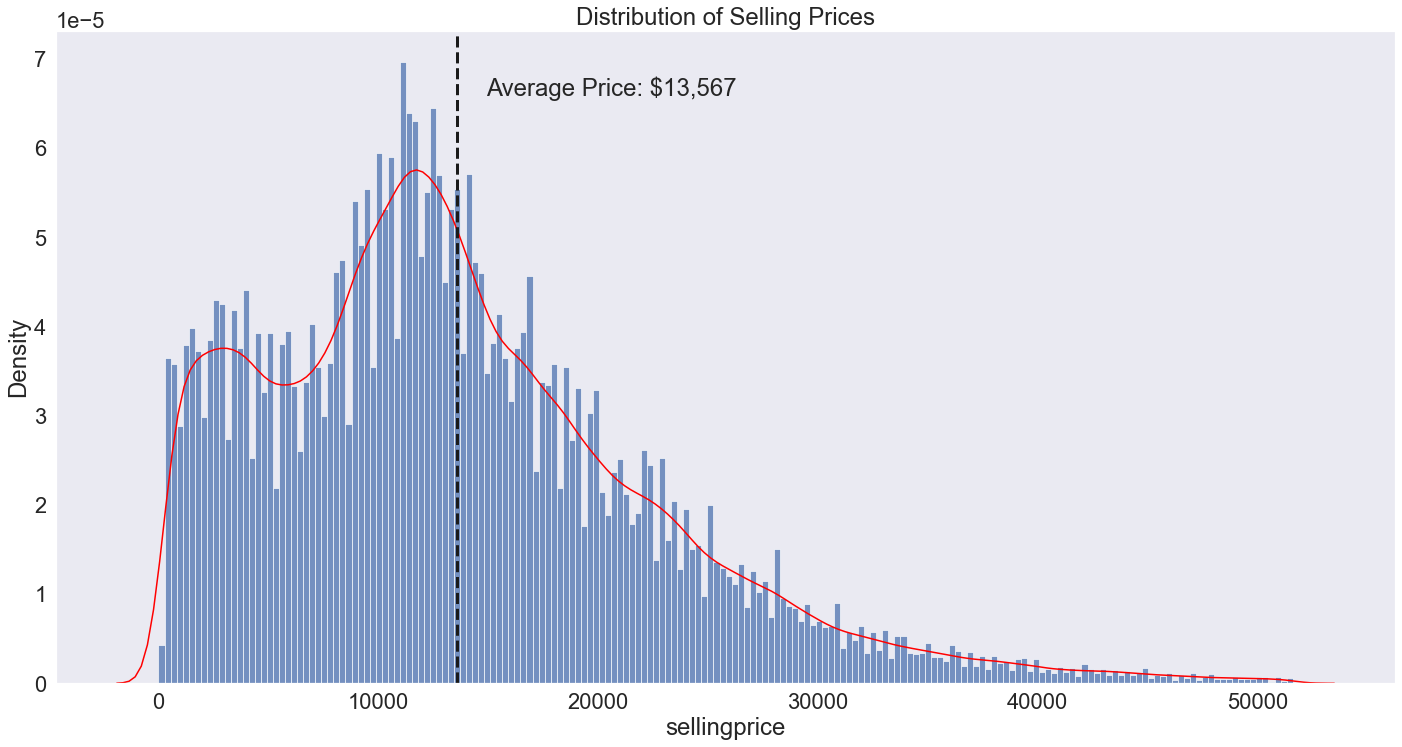

In [6]:
viz.plot_dist(df)

In [7]:
train, validate, test = wrangle.split_cars(df)

## How good is MMR at predicting sales price?

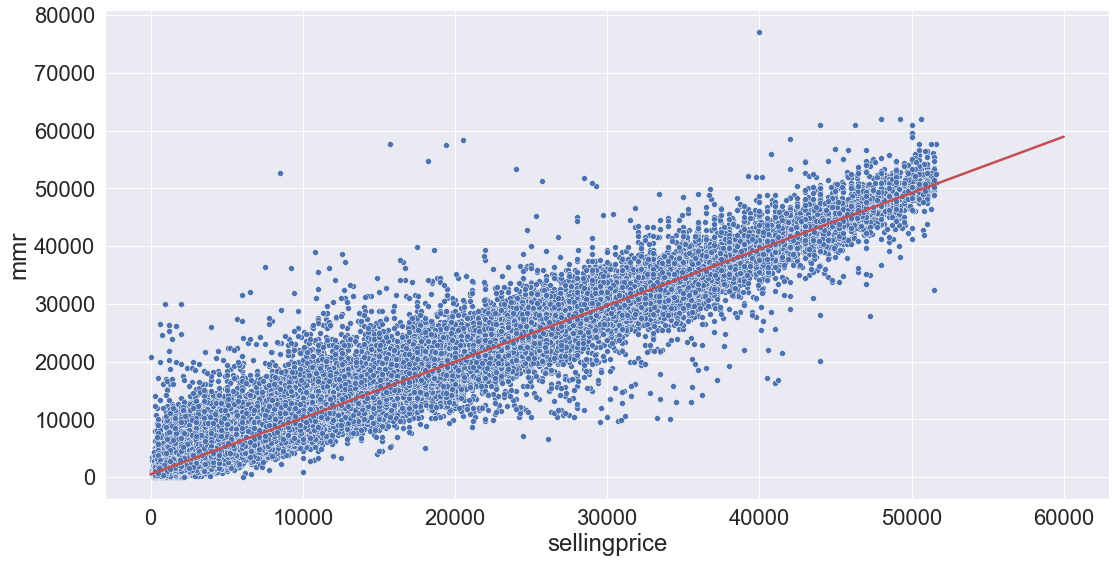

In [8]:
viz.mmr_plot(train)

In [9]:
rmse_mmr = round(mean_squared_error(train.sellingprice, train.mmr, squared=False),2)
r2_mmr = round(r2_score(train.sellingprice, train.mmr),4)
print(f'Baseline RMSE: ${rmse_mmr}, Baseline R2: {r2_mmr}')

Baseline RMSE: $1659.5, Baseline R2: 0.9641


In [10]:
# encode categorical variables using scaling based upon the target variable
cats=['trim', 'body', 'make', 'transmission', 'state', 'model', 'color', 'interior']
te = TargetEncoder()
t_values = te.fit_transform(X = train[cats], y = train.sellingprice).add_prefix('enc_')
train = pd.concat([train, t_values], axis = 1)

v_values = te.transform(X = validate[cats], y = validate.sellingprice).add_prefix('enc_')
validate = pd.concat([validate, v_values], axis = 1)

test_values = te.transform(X = test[cats], y = test.sellingprice).add_prefix('enc_')
test = pd.concat([test, test_values], axis = 1)

In [11]:
train.drop(columns=cats, inplace=True)
validate.drop(columns=cats, inplace=True)
test.drop(columns=cats, inplace=True)

In [12]:
train

,year,vin,condition,odometer,seller,mmr,sellingprice,saledate,saleyear,age_at_sale,miles_per_year,enc_trim,enc_body,enc_make,enc_transmission,enc_state,enc_model,enc_color,enc_interior
336904,2011,wddgf8bb8br160819,3.8,45791,r hollenshead auto sales inc,17850,19000,Fri Feb 20 2015 01:00:00 GMT-0800 (PST),2015,4,11447,19532.272727,11889.400451,20292.590389,13501.544463,15665.373120,17809.305141,17430.960037,11174.472730
378530,2007,5gzcz23d27s843143,2.6,107186,santander consumer,3725,4000,Wed Mar 04 2015 02:30:00 GMT-0800 (PST),2015,8,13398,13388.910195,15928.833354,3346.361880,10749.221372,13157.058296,3308.350305,11848.545933,11174.472730
429647,2013,1c3ccbcg9dn655571,4.2,19242,chrysler capital,13750,12700,Thu May 21 2015 02:30:00 GMT-0700 (PDT),2015,2,9621,16810.391909,11889.400451,11407.611934,13501.544463,15077.875355,11217.561102,15400.592426,13255.440016
304344,2005,1g1ak12f957574027,1.9,86046,peoples credit company inc,2575,2000,Fri Feb 13 2015 01:00:00 GMT-0800 (PST),2015,10,8604,13388.910195,14904.445245,11857.097298,13501.544463,15665.373120,3427.085506,11588.070085,11174.472730
61836,2013,jthbe1bl5d5024230,4.8,13668,lexus financial services,34800,35000,Tue Dec 30 2014 09:30:00 GMT-0800 (PST),2014,1,13668,13388.910195,11889.400451,20066.164373,13501.544463,13790.509741,28226.238739,11848.545933,11174.472730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322784,2013,1ftex1cm8dkf44584,3.3,14932,stratford hyundai,21400,17000,Thu Feb 26 2015 01:30:00 GMT-0800 (PST),2015,2,7466,15396.805112,17910.502881,14598.024132,13501.544463,15077.875355,19044.915488,14678.355350,12058.832016
367772,2005,1ftne24w85ha57041,2.0,185557,lease plan usa,2325,3600,Thu Feb 26 2015 03:00:00 GMT-0800 (PST),2015,10,18555,16040.920635,12509.516587,14598.024132,14781.753259,15026.781856,4692.857143,14678.355350,11174.472730
174249,2013,1g6ab5raxd0152822,3.9,33443,the hertz corporation,19500,19100,Fri Feb 13 2015 01:00:00 GMT-0800 (PST),2015,2,16721,20961.228346,11889.400451,15126.485392,14781.753259,15665.373120,20514.119658,9661.298541,15408.059705
338057,2014,2g1fc1e35e9185520,5.0,4793,smith haven chrysler jeep dodge,22600,23400,Fri Feb 20 2015 09:30:00 GMT-0800 (PST),2015,1,4793,13826.873969,14904.445245,11857.097298,14781.753259,15665.373120,19271.462037,11848.545933,15408.059705


In [39]:
cols=['vin', 'odometer', 'year','seller', 'saledate', 'sellingprice']

In [40]:
X_train = train.drop(columns = cols)
X_val = validate.drop(columns= cols)
X_test = test.drop(columns= cols)

y_train = train.sellingprice
y_val = validate.sellingprice
y_test = test.sellingprice

In [45]:
# build pipeline
pipeline = Pipeline([('scaler', MinMaxScaler()), ('model', xgb.XGBRegressor(eta=.1,
                                                                           gamma=0,
                                                                           min_child_weight=6,
                                                                           max_depth=8))])

In [46]:
# fit model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eta=0.1,
                              eval_metric=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.100000001, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=8, max_leaves=0, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_

In [47]:
# predict train and validation set
yhat_train = pipeline.predict(X_train)
yhat_val = pipeline.predict(X_val)

In [48]:
# evaluate
rmse_train = mean_squared_error(y_train, yhat_train, squared=False)
rmse_val = mean_squared_error(y_val, yhat_val, squared=False)
r2_train = r2_score(y_train, yhat_train)
r2_val = r2_score(y_val, yhat_val)
print(f'In-sample RMSE: {rmse_train}, In-sample r2: {r2_train}')
print(f'Out-of-sample RMSE: {rmse_val}, Out-of-sample r2: {r2_val}')

In-sample RMSE: 1269.6946180851508, In-sample r2: 0.9789750244510665
Out-of-sample RMSE: 1380.353267342948, Out-of-sample r2: 0.9751748555069844
